<h1><center> PPOL564 - Data Science I: Foundations </center><h1>
<h3><center> Lecture 17 <br><br><font color='grey'> Eigen Decompositions as Data Reduction </font></center></h3>

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings("ignore")

def download_data(git_loc,dest_name):
    '''
    Download data from Github and save to the notebook's working directory.
    '''
    req = requests.get(git_loc)
    with open(dest_name,"w") as file:
        for line in req.text:
            file.writelines(line)
            
download_data('https://raw.githubusercontent.com/edunford/ppol564/master/lectures/lecture_17/icews-repressive-actions-count.csv',
              "icews-repressive-actions-count.csv")

# Data

The following is data drawn from the ICEWS event data set. The ICEWS is a machine coding procedure that picks over an international database of news articles and codes in real time international and domestic events. The coding project seeks to classify a broad range of political activity for the purposes of prediction of political instability. For more on ICEWS and the CAMEO coding scheme in which events are cataloged and binned, see [here](https://en.wikipedia.org/wiki/Integrated_Conflict_Early_Warning_System) and the codebook at Harvard's [Dataverse](https://dataverse.harvard.edu/dataverse/icews). 

ICEWS seeks to track everything political. For todays purposes, I've filtered and cleaned these data to only reflect indicators that reflect "repressive" behavior of states toward their domestic populations for 5 countries from 1995 to 2014: China, Nigeria, United Kingdom, United States, and Zimbabwe. The data have been aggregated to the country-year. 

In a way, we can think of these data as the observable record of state repressive activities to its domestic population. We want to use these data to build a measure of state repressive behavior by year. 

In [2]:
dat = pd.read_csv('icews-repressive-actions-count.csv')
print(f'''
There are {dat.shape[0]} observations in the data and {dat.shape[1]} variables
''')
dat.head()


There are 100 observations in the data and 77 variables



,country,year,polity2,regime_type,"abduct,_hijack,_or_take_hostage",accuse,accuse_of_aggression,"accuse_of_crime,_corruption","accuse_of_espionage,_treason",accuse_of_human_rights_abuses,...,threaten_to_reduce_or_break_relations,threaten_to_reduce_or_stop_aid,threaten_with_administrative_sanctions,torture,use_as_human_shield,use_conventional_military_force,use_tactics_of_violent_repression,use_unconventional_violence,veto,violate_ceasefire
0,China,1995.0,-7,Non-democracy,0,12,0,0,1,1,...,1,0,0,1,0,8,6,1,0,0
1,China,1996.0,-7,Non-democracy,0,29,0,0,0,3,...,0,0,0,0,0,29,5,0,0,0
2,China,1997.0,-7,Non-democracy,2,28,0,2,0,1,...,0,0,0,2,0,22,7,1,0,0
3,China,1998.0,-7,Non-democracy,1,22,0,0,0,2,...,0,0,0,0,0,27,18,1,0,0
4,China,1999.0,-7,Non-democracy,0,34,0,0,1,3,...,0,0,0,2,0,74,13,0,0,0


As you'll quickly note, there are a **large** number of variables in these data. Some of the variables correspond with the unit of analysis (e.g. `country` and `year`) whereas others correspond with important covariates (e.g. [`polity2`]() and `regime_type`). The remaining variables, however, are counts of specific repressive event types as coded by ICEWS' automated CAMEO coding scheme. 

These variables are represented as counts, where the reported integer corresponds to the number of times that event type occurred within that respective country-year. 

Let's list off the entire list of variables contained in the dataset. As reported above there are 73 variables that report state repressive behavior.

In [3]:
# Let's subset our data to only include the repressive indicators
D_sub = dat.drop(['country','year','polity2','regime_type'],axis=1)

In [4]:
D_sub.columns

Index(['abduct,_hijack,_or_take_hostage', 'accuse', 'accuse_of_aggression',
       'accuse_of_crime,_corruption', 'accuse_of_espionage,_treason',
       'accuse_of_human_rights_abuses', 'accuse_of_war_crimes',
       'arrest,_detain,_or_charge_with_legal_action', 'assassinate',
       'attempt_to_assassinate', 'ban_political_parties_or_politicians',
       'bring_lawsuit_against', 'carry_out_suicide_bombing', 'coerce',
       'complain_officially', 'conduct_hunger_strike',
       'conduct_strike_or_boycott',
       'conduct_suicide,_car,_or_other_non-military_bombing',
       'confiscate_property', 'criticize_or_denounce', 'defy_norms,_law',
       'demonstrate_military_or_police_power', 'demonstrate_or_rally',
       'destroy_property', 'detonate_nuclear_weapons', 'employ_aerial_weapons',
       'engage_in_mass_killings', 'expel_or_deport_individuals',
       'expel_or_withdraw', 'expel_or_withdraw_peacekeepers', 'give_ultimatum',
       'halt_mediation', 'halt_negotiations',
       '

It should become immediately clear that **we have a problem here**. There are **too many variables** seeking to capture different dimensions of state repression. This is even more of a problem given the limited number of observations that we have.

If we were to use every variable, we'd run into estimation problems, but if we were to only use one or two repression dimensions, then we'd essentially be throwing away important information about the concept we care about. 

Below we'll explore using **dimension reduction** using nothing more than the linear algebra concepts that we've covered thus far in class. Specifically, the **_eigendecomposition_**!

# Exploring the Data: How do our repressive indicators relate to one another?

In [5]:
corr = D_sub.corr()
corr.round(2)

,"abduct,_hijack,_or_take_hostage",accuse,accuse_of_aggression,"accuse_of_crime,_corruption","accuse_of_espionage,_treason",accuse_of_human_rights_abuses,accuse_of_war_crimes,"arrest,_detain,_or_charge_with_legal_action",assassinate,attempt_to_assassinate,...,threaten_to_reduce_or_break_relations,threaten_to_reduce_or_stop_aid,threaten_with_administrative_sanctions,torture,use_as_human_shield,use_conventional_military_force,use_tactics_of_violent_repression,use_unconventional_violence,veto,violate_ceasefire
"abduct,_hijack,_or_take_hostage",1.00,0.63,0.13,0.35,0.25,0.51,0.25,0.32,0.26,0.38,...,-0.01,0.22,0.29,0.75,0.28,0.71,-0.06,0.53,0.23,0.44
accuse,0.63,1.00,0.37,0.26,0.17,0.47,0.50,0.41,0.41,0.36,...,0.28,0.49,0.26,0.45,0.29,0.79,-0.10,0.70,0.29,0.12
accuse_of_aggression,0.13,0.37,1.00,-0.10,0.03,-0.03,0.81,-0.02,0.14,-0.05,...,0.17,0.20,0.08,0.16,-0.02,0.34,-0.17,0.16,-0.01,0.09
"accuse_of_crime,_corruption",0.35,0.26,-0.10,1.00,-0.01,-0.00,-0.06,0.37,0.12,0.33,...,0.00,0.04,0.02,0.10,0.21,0.24,-0.00,0.21,-0.11,0.02
"accuse_of_espionage,_treason",0.25,0.17,0.03,-0.01,1.00,0.19,0.18,-0.03,0.09,-0.02,...,0.09,0.11,0.17,0.21,0.07,0.03,0.17,0.00,0.27,-0.07
accuse_of_human_rights_abuses,0.51,0.47,-0.03,-0.00,0.19,1.00,0.05,0.00,0.38,0.32,...,0.13,0.42,0.04,0.35,0.39,0.40,-0.12,0.36,0.13,0.03
accuse_of_war_crimes,0.25,0.50,0.81,-0.06,0.18,0.05,1.00,0.07,0.20,-0.05,...,0.14,0.17,0.14,0.20,0.09,0.38,-0.15,0.19,0.25,0.04
"arrest,_detain,_or_charge_with_legal_action",0.32,0.41,-0.02,0.37,-0.03,0.00,0.07,1.00,0.11,0.24,...,0.16,-0.03,0.31,0.21,0.07,0.34,0.45,0.22,0.12,0.02
assassinate,0.26,0.41,0.14,0.12,0.09,0.38,0.20,0.11,1.00,0.10,...,0.19,0.57,0.34,0.14,0.15,0.43,-0.15,0.18,0.23,-0.02
attempt_to_assassinate,0.38,0.36,-0.05,0.33,-0.02,0.32,-0.05,0.24,0.10,1.00,...,0.09,0.22,-0.02,0.21,-0.03,0.17,0.01,0.15,-0.03,-0.03


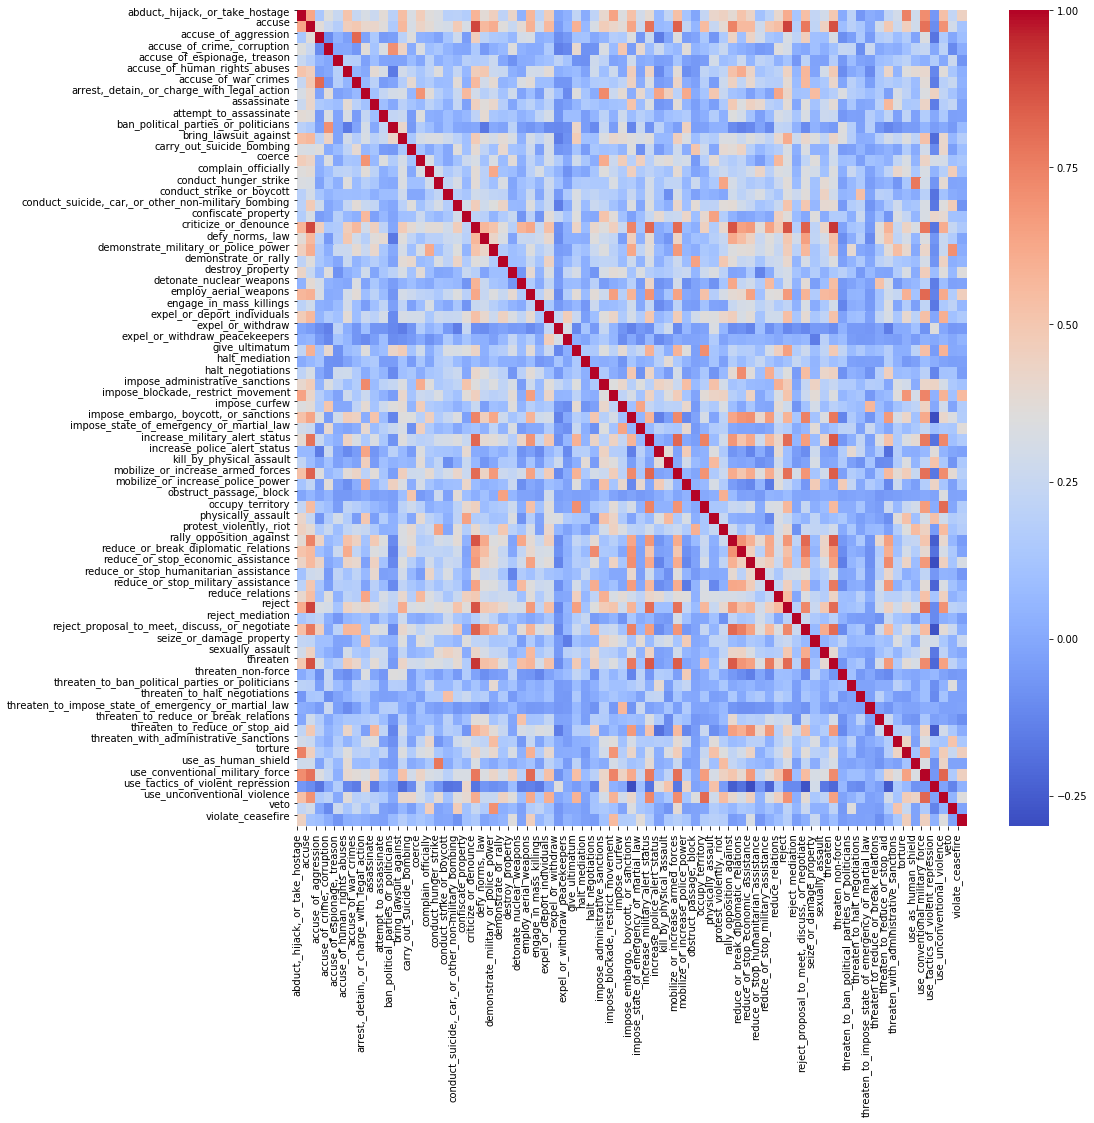

In [6]:
plt.figure(figsize=(15,15))
# Heat map of the correlations...
g = sns.heatmap(corr, cmap='coolwarm')
#Apply ticks
g = plt.xticks(range(len(corr.columns)), corr.columns)
g = plt.yticks(range(len(corr.columns)), corr.columns)

What can we say from the correlation of these variables?

# Eigen Decomposition 

As we saw last time, we can decompose a square matrix into a matrix of eigenvectors and eigenvalues. Here we will use our covariance matrix $\Sigma$

<br>
<br>

$$ \Sigma = \textbf{V}\Lambda\textbf{V}^{-1} $$

<br>
<br>

Where $\textbf{V}$ is a matrix of eigenvectors and $\Lambda$ is a diagonal matrix of eigenvalues.

<br>
<br>

When decomposing a covariance matrix, we are aiming to find the eigenvectors that maximum the variance of data. In a sense, the eigenvector with the largest eigenvalue tells most of the story in the data. What we are interested in is finding a single vector that broadly convey most of the information without having to use all of the data.  

In [7]:
# Decompose the covariance matrix
sigma = D_sub.cov()
evals,evecs = la.eig(sigma)

Let's look at our eigenvalues. What do these tell us? 

In [8]:
evals.round(3)

array([1.6705711e+05, 5.1008294e+04, 1.6071909e+04, 2.6249700e+03,
       1.4014640e+03, 9.0077300e+02, 7.0484600e+02, 5.6308500e+02,
       3.3004100e+02, 2.2765100e+02, 2.3428700e+02, 1.6815800e+02,
       1.3379300e+02, 1.0015100e+02, 8.4977000e+01, 5.8784000e+01,
       5.2017000e+01, 4.7654000e+01, 4.0190000e+01, 3.6322000e+01,
       3.3430000e+01, 2.7946000e+01, 2.4945000e+01, 1.9384000e+01,
       1.8430000e+01, 1.7319000e+01, 1.4263000e+01, 1.3373000e+01,
       1.0286000e+01, 9.1440000e+00, 7.3380000e+00, 6.1890000e+00,
       5.8080000e+00, 5.0660000e+00, 4.6990000e+00, 4.3700000e+00,
       3.7230000e+00, 3.1460000e+00, 2.7640000e+00, 2.5170000e+00,
       2.0970000e+00, 1.9050000e+00, 1.6620000e+00, 1.3570000e+00,
       1.1990000e+00, 1.2810000e+00, 1.2870000e+00, 9.6800000e-01,
       6.9100000e-01, 5.8900000e-01, 5.2500000e-01, 4.2800000e-01,
       3.2200000e-01, 2.8600000e-01, 2.1100000e-01, 1.5900000e-01,
       1.5500000e-01, 1.1500000e-01, 1.0700000e-01, 9.1000000e

Let's think back to what an eigenvalue is. It's the degree to which our eigenvector is being scaled up or down. Given that a covariance matrix is positively defined (why is this?), values are only scale up here. 

What can we say about the eigenvectors with extremely small eigenvalues?

### Explained Variance

Let's change how we evaluate the eigenvalues. Rather than think of them as scalars, let's think about them as weights. These weights determine the importance of a particular eigenvector. We want to choose the eigenvector that explains the most variation (i.e. tells the most of our data's story!).

In [9]:
# Let's convert our eigen values into proportions
variance_explained = evals/sum(abs(evals))

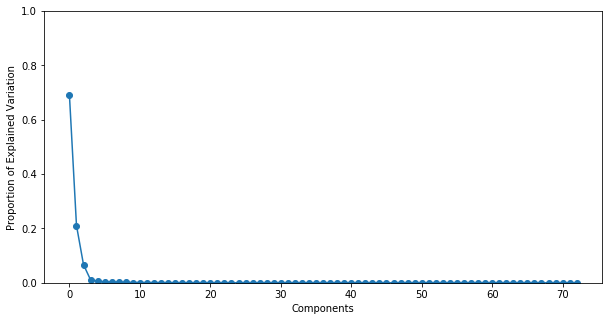

In [10]:
plt.figure(figsize=(10,5))
plt.plot(variance_explained,marker='o')
plt.xlabel("Components") 
plt.ylabel("Proportion of Explained Variation") 
plt.ylim(0,1)
plt.show()

In [11]:
print('Proportion of Variation Explained')
for i,val in enumerate(variance_explained):
    print(f'''
    Eigenvalue {i+1} accounts for {round(val*100,2)}% of the variance
    ''')

Proportion of Variation Explained

    Eigenvalue 1 accounts for 69.0% of the variance
    

    Eigenvalue 2 accounts for 21.07% of the variance
    

    Eigenvalue 3 accounts for 6.64% of the variance
    

    Eigenvalue 4 accounts for 1.08% of the variance
    

    Eigenvalue 5 accounts for 0.58% of the variance
    

    Eigenvalue 6 accounts for 0.37% of the variance
    

    Eigenvalue 7 accounts for 0.29% of the variance
    

    Eigenvalue 8 accounts for 0.23% of the variance
    

    Eigenvalue 9 accounts for 0.14% of the variance
    

    Eigenvalue 10 accounts for 0.09% of the variance
    

    Eigenvalue 11 accounts for 0.1% of the variance
    

    Eigenvalue 12 accounts for 0.07% of the variance
    

    Eigenvalue 13 accounts for 0.06% of the variance
    

    Eigenvalue 14 accounts for 0.04% of the variance
    

    Eigenvalue 15 accounts for 0.04% of the variance
    

    Eigenvalue 16 accounts for 0.02% of the variance
    

    Eigenvalue 17 accounts for

Let's change our language a bit here. Rather than referring constantly to the eigenvalue/eigenvector, let's call the combination a **"principal component"**.

The above plot and printout shows that **most of the variance (97%) can be explained by the first three eigenvectors**. The rest of the eigenvectors account for very little of the variation. That is, their eigenvalues barely scale the eigenvectors. 

We can read this as there are really only three real underlying dimensions that explain the variation in the data matrix. 

This is useful because we can reduce our 73 indicators down to three principal components that retain and account for the underlying variation in the data.

# Generating Scores

We can now project our data down into three dimensions using our eigenvectors/eigenvalues. Let's subset our matrix of eigenvectors that correspond with the first three eigenvalues that explain the most variation in the data. 

The eigenvectors can be thought of as **_weights_** that describe how each indicator loads onto the underlying dimension. 

<br>
<br>

$$ \textbf{X}_{n \times p} \textbf{V}^*_{p \times s} =  \textbf{S}_{n \times s}$$

<br>
<br>

where $\textbf{X}$ is our original ${n\times p}$ data matrix, $\textbf{V}^* \subset \textbf{V}~|~s < p$ of eigenvectors and $\textbf{S}$ is an ${n \times s}$ matrix of projected scores.

In [12]:
# Extract the first three eigenvectors
weights = evecs[:,[0,1,2]]
weights.shape

(73, 3)

We can now project our data onto these weights to create three variables that project onto these subspaces.

In [13]:
X = D_sub.values                      # Convert data to the numerical matrix
reduced_data = X.dot(weights)         # Project data onto the eigenvectors
reduced_data.shape

(100, 3)

In [14]:
# Let's save this to our data to our data frame
def standardize(x):
    '''
    Set mean equal to 0 and variance equal to 1
    '''
    return (x-np.mean(x))/np.std(x)

dat['comp_1'] = standardize(reduced_data[:,0])
dat['comp_2'] = standardize(reduced_data[:,1])
dat['comp_3'] = standardize(reduced_data[:,2])
dat2 = dat[['country','year','polity2','regime_type','comp_1','comp_2','comp_3']]
dat2.head()

,country,year,polity2,regime_type,comp_1,comp_2,comp_3
0,China,1995.0,-7,Non-democracy,0.755175,0.460266,0.316986
1,China,1996.0,-7,Non-democracy,0.617021,0.118523,0.277331
2,China,1997.0,-7,Non-democracy,0.698467,0.555486,0.188908
3,China,1998.0,-7,Non-democracy,0.576978,-0.074490,0.216587
4,China,1999.0,-7,Non-democracy,0.303260,-0.683403,0.137371


### Validation?

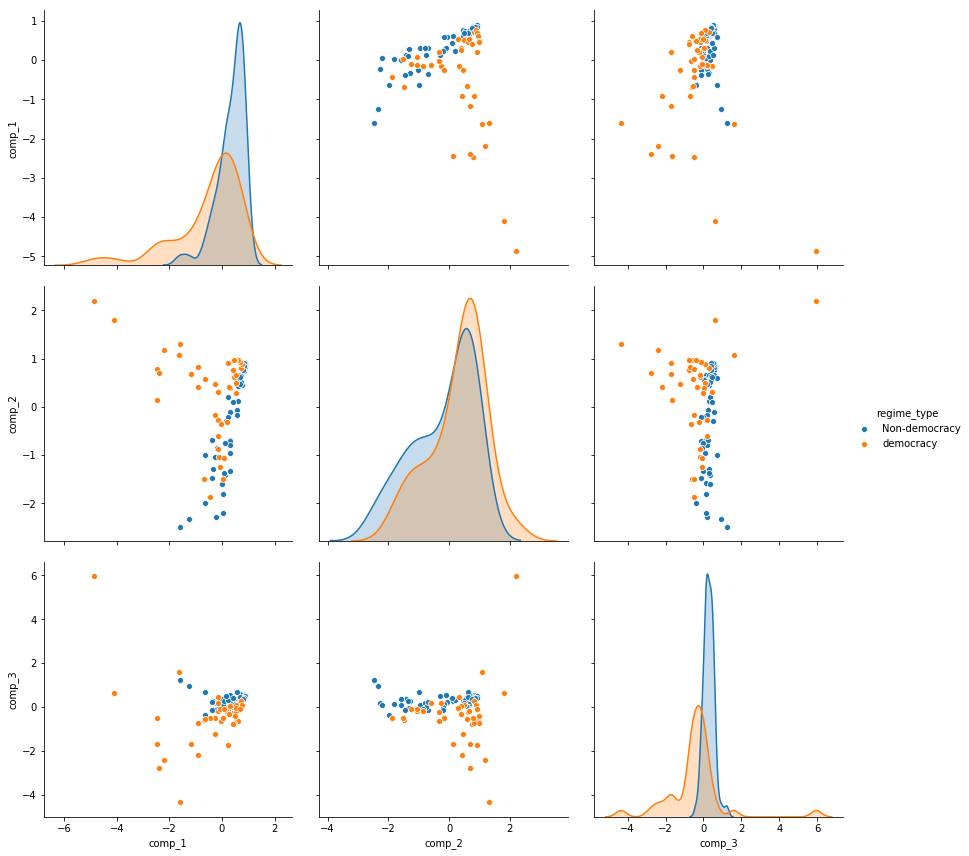

In [15]:
g = sns.pairplot(dat2[['comp_1','comp_2','comp_3','regime_type']],hue="regime_type",height=4)

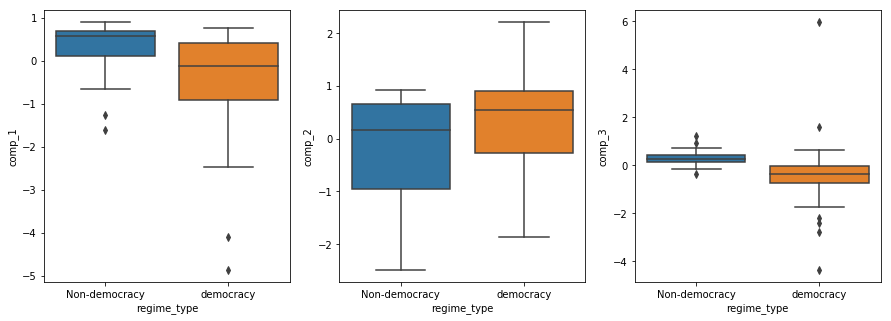

In [16]:
f, axes = plt.subplots(1, 3,figsize=(15,5))
g = sns.boxplot(y="comp_1", x="regime_type", data=dat2,ax=axes[0])
g = sns.boxplot(y="comp_2", x="regime_type", data=dat2,ax=axes[1])
g = sns.boxplot(y="comp_3", x="regime_type", data=dat2,ax=axes[2])

**The above poses an interesting question: _Is reduced data still useful even if we can't associate the collapsed dimensions with a concept?_**